In [1]:
#导入相关依赖库
import  os
from matplotlib import pyplot as plt
import numpy as np

import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy

from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='CPU')


In [2]:
DATA_DIR_TRAIN = "MNIST/train" # 训练集信息
DATA_DIR_TEST = "MNIST/test" # 测试集信息
#读取数据
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST ) 
#显示数据集的相关特性
print('训练数据集数量：',ds_train.get_dataset_size())
print('测试数据集数量：',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('图像长/宽/通道数：',image['image'].shape)
print('一张图像的标签样式：',image['label'])    #一共10类，用0-9的数字表达类别。


训练数据集数量： 60000
测试数据集数量： 10000
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 9


In [3]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # 定义Map操作尺寸缩放，归一化和通道变换
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale,shift)
    hwc2chw_op = CV.HWC2CHW()
    # 对数据集进行map操作
    ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    #设定打乱操作参数和batchsize大小
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds


[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:30:47.882.322 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:30:47.883.864 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:30:47.884.773 [mindspore/dataset/core/validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:30:47.885.928 [mindspore/dat

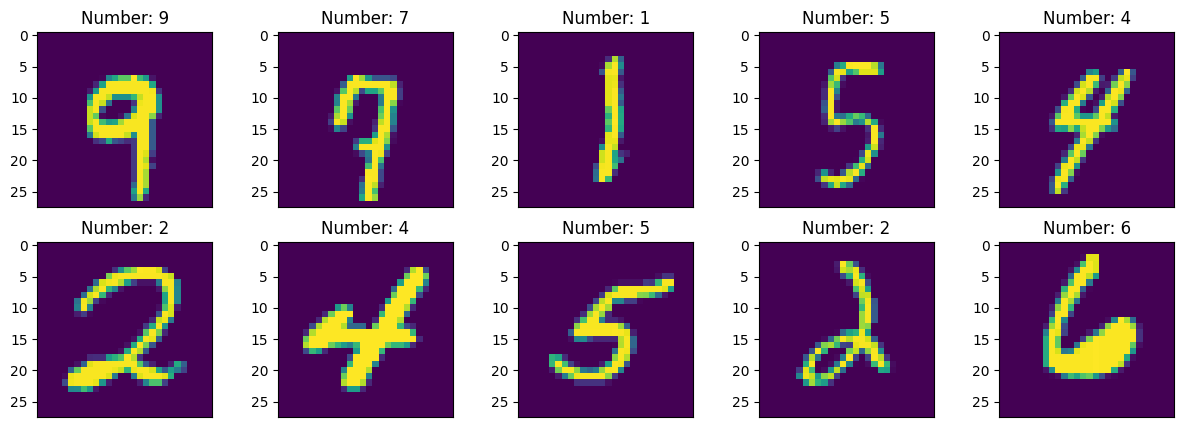

In [4]:
#显示前10张图片以及对应标签,检查图片是否是正确的数据集
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


In [5]:
#创建模型。模型包括3个全连接层，最后输出层使用softmax进行多分类，共分成（0-9）10类
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation='relu')  
        self.fc2 = nn.Dense(512, 128, activation='relu')
        self.fc3 = nn.Dense(128, 10, activation=None)
       
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output) 
        output = self.fc3(output)
        return output  


In [6]:
#创建网络，损失函数，评估指标  优化器，设定相关超参数
lr = 0.001
num_epoch = 10
momentum = 0.9

net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr) 


In [7]:
#编译模型
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)
#生成数据集
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)
#训练模型
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)


[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:31:05.885.683 [mindspore/dataset/core/validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:31:05.886.806 [mindspore/dataset/core/validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:31:05.888.144 [mindspore/dataset/core/validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(41085:139958250325824,MainProcess):2024-08-14-17:31:05.889.817 [mindspore/dat

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.01147345919162035
Train epoch time: 7148.100 ms, per step time: 3.812 ms
epoch: 2 step: 1875, loss is 0.023888975381851196
Train epoch time: 6309.191 ms, per step time: 3.365 ms
epoch: 3 step: 1875, loss is 0.11368030309677124
Train epoch time: 6457.958 ms, per step time: 3.444 ms
epoch: 4 step: 1875, loss is 0.017362091690301895
Train epoch time: 7455.979 ms, per step time: 3.977 ms
epoch: 5 step: 1875, loss is 0.0007836223230697215
Train epoch time: 6617.086 ms, per step time: 3.529 ms
epoch: 6 step: 1875, loss is 0.01729661412537098
Train epoch time: 6565.260 ms, per step time: 3.501 ms
epoch: 7 step: 1875, loss is 0.001522732782177627
Train epoch time: 6767.596 ms, per step time: 3.609 ms
epoch: 8 step: 1875, loss is 0.004574342165142298
Train epoch time: 6445.516 ms, per step time: 3.438 ms
epoch: 9 step: 1875, loss is 0.0011980949202552438
Train epoch time: 6291.481 ms, per step time: 3.355 ms
epoch: 1

In [8]:
#使用测试集评估模型，打印总体准确率
metrics=model.eval(ds_eval)
print(metrics)



{'Accuracy': 0.9797676282051282}
